In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import copy
import json

USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

def deep_copy_lists(filter_word, filter_ent, filter_rel):
    f_w = copy.deepcopy(filter_word)
    f_e = copy.deepcopy(filter_ent)
    f_r = copy.deepcopy(filter_rel)
    
    return f_w, f_e, f_r

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=2,       
#         drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output)
        self.w2 = nn.Linear(self.attn_input, self.attn_output)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(DENSE_OUT, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, self.batch, self.hidden_dim1 // 2)    #4*B*(h1/2)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(self.batch, self.hidden_dim2)              #B*h2

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(self.batch, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(self.batch, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(self.batch, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence, batch_ent, isTrain=True):
        
        self.batch = sentence.size(0)
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        

        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        # bn
        bilstm_out = self.bn(bilstm_out)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            
            if length==0:
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]  
            s_ent_output = self.softmax_entity(ent_output)
            ent_onehot = self.one_hot(s_ent_output)
            
            
            if isTrain:
                label = self.label_embed(ent_onehot)                             #B*LE,[128, 3]
#                 label = self.label_embed(ent_output) 
            else:
                batch_ent_onehot = self.one_hot(batch_ent[:,length])
                label = self.label_embed(batch_ent_onehot)
            

            
            
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
#             encoder_sequence_l.append(torch.cat((to_tags,label),1)) 
            encoder_sequence_l.append(torch.cat((h_next,label),1))  
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(self.batch*MAX_LEN, self.ent_size), \
               rel_tensor.view(self.batch*MAX_LEN*MAX_LEN, self.rel_size)
        
        
    def softmax_entity(self, entity):
        entity = entity.view(self.batch,ent_size).argmax(1)
        return entity
    
    
    def one_hot(self, batch_ent):   
        batchsize = batch_ent.size(0)
        nb_digits = len(ent_tag_to_ix)
        batch_ent = torch.unsqueeze(batch_ent, 1)
        y_onehot = torch.cuda.FloatTensor(batchsize, nb_digits)        
        y_onehot.zero_()
        y_onehot.scatter_(1, batch_ent, 1)    

        return y_onehot

In [5]:
root = '/notebooks/sinica/dataset/'
train_data = root+'facial.train'
dev_data = root+'facial.dev'
test_data = root+'facial.test'

relation_data_old = root+'facial_r.old.train'
# relation_data = root+'facial_r.train'
relation_data = root+'facial_r2.train'
schema_root = root+'schema.txt'
dev_data = root+'facial_r2.dev'
test_data = root+'facial_r2.test'


UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'
rule = ('FUNC', 'ApplyTo', 'STAT')

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 100
BATCH_SIZE = 18

EMBEDDING_DIM = 20
HIDDEN_DIM1 = 10
HIDDEN_DIM2 = 8
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

# ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_IN = HIDDEN_DIM2+LABEL_EMBED_DIM
ATTN_OUT = 6

In [6]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [7]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss()
criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 70
print_every = 12
all_ent_loss = []
all_rel_loss = []
total_loss = 0 # Reset every plot_every iters
loss = 0
ent_loss = 0

start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        batch_ent = batch_ent.view(batchsize*MAX_LEN)
        batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)
        
        loss_ent = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
        loss_rel = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
        loss = loss_ent+loss_rel
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        
        if step % print_every == 1:
            all_ent_loss.append(loss_ent.cpu())
            all_rel_loss.append(loss_rel.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
        
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        val_loss_ent = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
        val_loss_rel = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch, loss_ent, loss_rel, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch)), val_loss_ent, val_loss_rel))


  1%|▏         | 1/70 [00:07<08:47,  7.65s/it]

epoch: 0 | ent loss 0.5779 | rel loss 0.0632 | total loss 0.6411
         | val ent loss 0.5251 | val rel loss 0.0551


  3%|▎         | 2/70 [00:15<08:31,  7.52s/it]

epoch: 1 | ent loss 0.3479 | rel loss 0.0173 | total loss 0.3652
         | val ent loss 0.3270 | val rel loss 0.0161


  4%|▍         | 3/70 [00:22<08:24,  7.52s/it]

epoch: 2 | ent loss 0.3171 | rel loss 0.0114 | total loss 0.3285
         | val ent loss 0.2730 | val rel loss 0.0090


  6%|▌         | 4/70 [00:30<08:15,  7.51s/it]

epoch: 3 | ent loss 0.2865 | rel loss 0.0088 | total loss 0.2953
         | val ent loss 0.2467 | val rel loss 0.0078


  7%|▋         | 5/70 [00:38<08:21,  7.72s/it]

epoch: 4 | ent loss 0.1923 | rel loss 0.0071 | total loss 0.1994
         | val ent loss 0.2059 | val rel loss 0.0075


  9%|▊         | 6/70 [00:46<08:19,  7.81s/it]

epoch: 5 | ent loss 0.1667 | rel loss 0.0055 | total loss 0.1722
         | val ent loss 0.1595 | val rel loss 0.0055


 10%|█         | 7/70 [00:55<08:16,  7.88s/it]

epoch: 6 | ent loss 0.1549 | rel loss 0.0054 | total loss 0.1603
         | val ent loss 0.1487 | val rel loss 0.0042


 11%|█▏        | 8/70 [01:02<08:07,  7.86s/it]

epoch: 7 | ent loss 0.1603 | rel loss 0.0050 | total loss 0.1652
         | val ent loss 0.1448 | val rel loss 0.0042


 13%|█▎        | 9/70 [01:10<08:00,  7.87s/it]

epoch: 8 | ent loss 0.1214 | rel loss 0.0046 | total loss 0.1260
         | val ent loss 0.1249 | val rel loss 0.0040


 14%|█▍        | 10/70 [01:18<07:50,  7.84s/it]

epoch: 9 | ent loss 0.1148 | rel loss 0.0042 | total loss 0.1190
         | val ent loss 0.1344 | val rel loss 0.0038


 16%|█▌        | 11/70 [01:26<07:42,  7.83s/it]

epoch: 10 | ent loss 0.1037 | rel loss 0.0031 | total loss 0.1068
          | val ent loss 0.1203 | val rel loss 0.0030


 17%|█▋        | 12/70 [01:33<07:33,  7.82s/it]

epoch: 11 | ent loss 0.0950 | rel loss 0.0036 | total loss 0.0986
          | val ent loss 0.1135 | val rel loss 0.0038


 19%|█▊        | 13/70 [01:41<07:24,  7.80s/it]

epoch: 12 | ent loss 0.0963 | rel loss 0.0037 | total loss 0.1001
          | val ent loss 0.0996 | val rel loss 0.0032


 20%|██        | 14/70 [01:48<07:14,  7.76s/it]

epoch: 13 | ent loss 0.0874 | rel loss 0.0033 | total loss 0.0906
          | val ent loss 0.0804 | val rel loss 0.0026


 21%|██▏       | 15/70 [01:56<07:06,  7.76s/it]

epoch: 14 | ent loss 0.0829 | rel loss 0.0028 | total loss 0.0858
          | val ent loss 0.0882 | val rel loss 0.0023


 23%|██▎       | 16/70 [02:03<06:56,  7.71s/it]

epoch: 15 | ent loss 0.0786 | rel loss 0.0031 | total loss 0.0817
          | val ent loss 0.0892 | val rel loss 0.0022


 24%|██▍       | 17/70 [02:10<06:47,  7.68s/it]

epoch: 16 | ent loss 0.0546 | rel loss 0.0028 | total loss 0.0575
          | val ent loss 0.0782 | val rel loss 0.0023


 26%|██▌       | 18/70 [02:18<06:39,  7.68s/it]

epoch: 17 | ent loss 0.0475 | rel loss 0.0025 | total loss 0.0500
          | val ent loss 0.0877 | val rel loss 0.0026


 27%|██▋       | 19/70 [02:26<06:34,  7.73s/it]

epoch: 18 | ent loss 0.0580 | rel loss 0.0024 | total loss 0.0604
          | val ent loss 0.0571 | val rel loss 0.0021


 29%|██▊       | 20/70 [02:34<06:27,  7.74s/it]

epoch: 19 | ent loss 0.0551 | rel loss 0.0025 | total loss 0.0576
          | val ent loss 0.0821 | val rel loss 0.0027


 30%|███       | 21/70 [02:42<06:19,  7.75s/it]

epoch: 20 | ent loss 0.0397 | rel loss 0.0022 | total loss 0.0419
          | val ent loss 0.0444 | val rel loss 0.0024


 31%|███▏      | 22/70 [02:50<06:12,  7.75s/it]

epoch: 21 | ent loss 0.0350 | rel loss 0.0023 | total loss 0.0372
          | val ent loss 0.0621 | val rel loss 0.0019


 33%|███▎      | 23/70 [02:57<06:03,  7.74s/it]

epoch: 22 | ent loss 0.0405 | rel loss 0.0028 | total loss 0.0433
          | val ent loss 0.0668 | val rel loss 0.0020


 34%|███▍      | 24/70 [03:04<05:54,  7.71s/it]

epoch: 23 | ent loss 0.0262 | rel loss 0.0024 | total loss 0.0287
          | val ent loss 0.0429 | val rel loss 0.0020


 36%|███▌      | 25/70 [03:11<05:45,  7.67s/it]

epoch: 24 | ent loss 0.0223 | rel loss 0.0022 | total loss 0.0245
          | val ent loss 0.0532 | val rel loss 0.0021


 37%|███▋      | 26/70 [03:18<05:36,  7.65s/it]

epoch: 25 | ent loss 0.0162 | rel loss 0.0024 | total loss 0.0186
          | val ent loss 0.0761 | val rel loss 0.0016


 39%|███▊      | 27/70 [03:26<05:29,  7.66s/it]

epoch: 26 | ent loss 0.0133 | rel loss 0.0019 | total loss 0.0153
          | val ent loss 0.0802 | val rel loss 0.0018


 40%|████      | 28/70 [03:34<05:21,  7.64s/it]

epoch: 27 | ent loss 0.0186 | rel loss 0.0019 | total loss 0.0206
          | val ent loss 0.0602 | val rel loss 0.0013


 41%|████▏     | 29/70 [03:41<05:12,  7.62s/it]

epoch: 28 | ent loss 0.0172 | rel loss 0.0018 | total loss 0.0189
          | val ent loss 0.0336 | val rel loss 0.0015


 43%|████▎     | 30/70 [03:48<05:04,  7.60s/it]

epoch: 29 | ent loss 0.0173 | rel loss 0.0023 | total loss 0.0196
          | val ent loss 0.0587 | val rel loss 0.0016


 44%|████▍     | 31/70 [03:55<04:55,  7.58s/it]

epoch: 30 | ent loss 0.0117 | rel loss 0.0020 | total loss 0.0136
          | val ent loss 0.0449 | val rel loss 0.0017


 46%|████▌     | 32/70 [04:01<04:47,  7.56s/it]

epoch: 31 | ent loss 0.0104 | rel loss 0.0019 | total loss 0.0123
          | val ent loss 0.0807 | val rel loss 0.0017


 47%|████▋     | 33/70 [04:09<04:39,  7.55s/it]

epoch: 32 | ent loss 0.0110 | rel loss 0.0017 | total loss 0.0127
          | val ent loss 0.0639 | val rel loss 0.0014


 49%|████▊     | 34/70 [04:15<04:31,  7.53s/it]

epoch: 33 | ent loss 0.0131 | rel loss 0.0025 | total loss 0.0156
          | val ent loss 0.0771 | val rel loss 0.0014


 50%|█████     | 35/70 [04:22<04:22,  7.49s/it]

epoch: 34 | ent loss 0.0145 | rel loss 0.0019 | total loss 0.0164
          | val ent loss 0.0787 | val rel loss 0.0013


 51%|█████▏    | 36/70 [04:27<04:12,  7.42s/it]

epoch: 35 | ent loss 0.0100 | rel loss 0.0019 | total loss 0.0119
          | val ent loss 0.0712 | val rel loss 0.0019


 53%|█████▎    | 37/70 [04:34<04:04,  7.41s/it]

epoch: 36 | ent loss 0.0141 | rel loss 0.0015 | total loss 0.0157
          | val ent loss 0.0421 | val rel loss 0.0016


 54%|█████▍    | 38/70 [04:41<03:56,  7.40s/it]

epoch: 37 | ent loss 0.0087 | rel loss 0.0017 | total loss 0.0105
          | val ent loss 0.0334 | val rel loss 0.0017


 56%|█████▌    | 39/70 [04:48<03:49,  7.39s/it]

epoch: 38 | ent loss 0.0109 | rel loss 0.0018 | total loss 0.0127
          | val ent loss 0.1022 | val rel loss 0.0014


 57%|█████▋    | 40/70 [04:55<03:41,  7.39s/it]

epoch: 39 | ent loss 0.0067 | rel loss 0.0016 | total loss 0.0083
          | val ent loss 0.0725 | val rel loss 0.0014


 59%|█████▊    | 41/70 [05:02<03:34,  7.38s/it]

epoch: 40 | ent loss 0.0160 | rel loss 0.0014 | total loss 0.0174
          | val ent loss 0.0830 | val rel loss 0.0013


 60%|██████    | 42/70 [05:09<03:26,  7.37s/it]

epoch: 41 | ent loss 0.0062 | rel loss 0.0014 | total loss 0.0076
          | val ent loss 0.0753 | val rel loss 0.0012


 61%|██████▏   | 43/70 [05:16<03:18,  7.36s/it]

epoch: 42 | ent loss 0.0053 | rel loss 0.0013 | total loss 0.0066
          | val ent loss 0.0630 | val rel loss 0.0015


 63%|██████▎   | 44/70 [05:23<03:11,  7.35s/it]

epoch: 43 | ent loss 0.0114 | rel loss 0.0018 | total loss 0.0132
          | val ent loss 0.0704 | val rel loss 0.0013


 64%|██████▍   | 45/70 [05:30<03:03,  7.34s/it]

epoch: 44 | ent loss 0.0301 | rel loss 0.0018 | total loss 0.0319
          | val ent loss 0.0418 | val rel loss 0.0014


 66%|██████▌   | 46/70 [05:35<02:54,  7.28s/it]

epoch: 45 | ent loss 0.0066 | rel loss 0.0015 | total loss 0.0081
          | val ent loss 0.0738 | val rel loss 0.0010


 67%|██████▋   | 47/70 [05:41<02:46,  7.26s/it]

epoch: 46 | ent loss 0.0070 | rel loss 0.0011 | total loss 0.0081
          | val ent loss 0.0408 | val rel loss 0.0010


 69%|██████▊   | 48/70 [05:48<02:39,  7.26s/it]

epoch: 47 | ent loss 0.0046 | rel loss 0.0012 | total loss 0.0058
          | val ent loss 0.0516 | val rel loss 0.0011


 70%|███████   | 49/70 [05:56<02:32,  7.27s/it]

epoch: 48 | ent loss 0.0080 | rel loss 0.0016 | total loss 0.0096
          | val ent loss 0.0568 | val rel loss 0.0014


 71%|███████▏  | 50/70 [06:04<02:25,  7.29s/it]

epoch: 49 | ent loss 0.0051 | rel loss 0.0014 | total loss 0.0065
          | val ent loss 0.0488 | val rel loss 0.0008


 73%|███████▎  | 51/70 [06:13<02:18,  7.31s/it]

epoch: 50 | ent loss 0.0086 | rel loss 0.0014 | total loss 0.0101
          | val ent loss 0.0887 | val rel loss 0.0010


 74%|███████▍  | 52/70 [06:21<02:11,  7.33s/it]

epoch: 51 | ent loss 0.0060 | rel loss 0.0013 | total loss 0.0072
          | val ent loss 0.0484 | val rel loss 0.0009


 76%|███████▌  | 53/70 [06:27<02:04,  7.32s/it]

epoch: 52 | ent loss 0.0066 | rel loss 0.0012 | total loss 0.0078
          | val ent loss 0.0746 | val rel loss 0.0013


 77%|███████▋  | 54/70 [06:36<01:57,  7.33s/it]

epoch: 53 | ent loss 0.0049 | rel loss 0.0012 | total loss 0.0061
          | val ent loss 0.0520 | val rel loss 0.0013


 79%|███████▊  | 55/70 [06:43<01:50,  7.34s/it]

epoch: 54 | ent loss 0.0113 | rel loss 0.0012 | total loss 0.0125
          | val ent loss 0.0812 | val rel loss 0.0012


 80%|████████  | 56/70 [06:51<01:42,  7.35s/it]

epoch: 55 | ent loss 0.0089 | rel loss 0.0011 | total loss 0.0100
          | val ent loss 0.0618 | val rel loss 0.0012


 81%|████████▏ | 57/70 [06:57<01:35,  7.33s/it]

epoch: 56 | ent loss 0.0041 | rel loss 0.0010 | total loss 0.0051
          | val ent loss 0.0512 | val rel loss 0.0011


 83%|████████▎ | 58/70 [07:05<01:27,  7.33s/it]

epoch: 57 | ent loss 0.0044 | rel loss 0.0012 | total loss 0.0055
          | val ent loss 0.0322 | val rel loss 0.0010


 84%|████████▍ | 59/70 [07:12<01:20,  7.32s/it]

epoch: 58 | ent loss 0.0039 | rel loss 0.0011 | total loss 0.0050
          | val ent loss 0.0750 | val rel loss 0.0011


 86%|████████▌ | 60/70 [07:19<01:13,  7.32s/it]

epoch: 59 | ent loss 0.0049 | rel loss 0.0010 | total loss 0.0060
          | val ent loss 0.0813 | val rel loss 0.0011


 87%|████████▋ | 61/70 [07:26<01:05,  7.33s/it]

epoch: 60 | ent loss 0.0049 | rel loss 0.0011 | total loss 0.0061
          | val ent loss 0.0425 | val rel loss 0.0011


 89%|████████▊ | 62/70 [07:34<00:58,  7.32s/it]

epoch: 61 | ent loss 0.0058 | rel loss 0.0011 | total loss 0.0069
          | val ent loss 0.0787 | val rel loss 0.0009


 90%|█████████ | 63/70 [07:41<00:51,  7.32s/it]

epoch: 62 | ent loss 0.0038 | rel loss 0.0012 | total loss 0.0050
          | val ent loss 0.0395 | val rel loss 0.0014


 91%|█████████▏| 64/70 [07:48<00:43,  7.32s/it]

epoch: 63 | ent loss 0.0043 | rel loss 0.0010 | total loss 0.0054
          | val ent loss 0.0281 | val rel loss 0.0009


 93%|█████████▎| 65/70 [07:55<00:36,  7.32s/it]

epoch: 64 | ent loss 0.0049 | rel loss 0.0013 | total loss 0.0061
          | val ent loss 0.0655 | val rel loss 0.0011


 94%|█████████▍| 66/70 [08:03<00:29,  7.32s/it]

epoch: 65 | ent loss 0.0068 | rel loss 0.0011 | total loss 0.0080
          | val ent loss 0.0328 | val rel loss 0.0010


 96%|█████████▌| 67/70 [08:10<00:21,  7.33s/it]

epoch: 66 | ent loss 0.0063 | rel loss 0.0011 | total loss 0.0074
          | val ent loss 0.0372 | val rel loss 0.0008


 97%|█████████▋| 68/70 [08:18<00:14,  7.33s/it]

epoch: 67 | ent loss 0.0087 | rel loss 0.0009 | total loss 0.0095
          | val ent loss 0.0829 | val rel loss 0.0012


 99%|█████████▊| 69/70 [08:25<00:07,  7.32s/it]

epoch: 68 | ent loss 0.0074 | rel loss 0.0011 | total loss 0.0085
          | val ent loss 0.0640 | val rel loss 0.0010


100%|██████████| 70/70 [08:32<00:00,  7.33s/it]

epoch: 69 | ent loss 0.0099 | rel loss 0.0011 | total loss 0.0110
          | val ent loss 0.0936 | val rel loss 0.0012


In [11]:
# save and load model
torch.save(model.state_dict(), 'relation_extraction_1.pkl')

# model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
#               LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
# model.load_state_dict(torch.load('relation_extraction.pkl'))

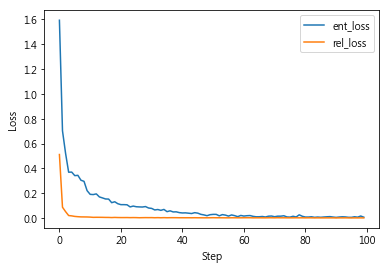

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(all_ent_loss[:100], label='ent_loss')
plt.plot(all_rel_loss[:100], label='rel_loss')
plt.xlabel("Step")
plt.ylabel("Loss") 
plt.legend()
plt.show()

In [13]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [14]:
# Check predictions after training
with torch.no_grad():
    r_choose = random_choose(input_var)
    model.eval()
    ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
    
    batchsize = input_var[r_choose].size(0)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
    ent_output = ent_argmax(ent_output, batchsize)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    
#     print('predict :', ent_output[0])
#     print('true :', ent_var[r_choose[0]])
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    print()
    print('===================================================')
    print()
    print()
    print('predict :', index2tag(ent_output[1], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[1]], ix_to_ent_tag))
    
    print()
    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)


predict : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
true : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [15]:
from sklearn.metrics import precision_recall_fscore_support


# entity分數 B開頭才算，整個entity一起算  I開頭忽略
# 每個epoch print recall validation 
# 之後可做，自動標rel

def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel):
    rel_lists = []
    true_rel_lists = []
    combine_ent_outputs, combine_ent_trues = [], []
    combine_rel_outputs, combine_rel_trues = [], []
    total_score_outputs, total_score_trues = [], []
    er_score_outputs, er_score_trues = [], []

    #================
    
    
    for e,r,i,te,tr in zip(ent_output, rel_output, batch_index, true_ent, true_rel):
        
        # 算句子長度
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        true_ent = index2tag(te, ix_to_ent_tag)[:len_of_list]
        pridict_ent = index2tag(e, ix_to_ent_tag)[:len_of_list]
       
        
        # 單句decode關係
        true_r_list, appear_error = decode_rel(te, tr)   # true
        r_list, appear_error = decode_rel(e, r)          # predict
        
        true_r_list = [list(set(i)) if type(i) is list else i for i in true_r_list]
        r_list = [list(set(i)) if type(i) is list else i for i in r_list]
        
        # 出現error，跳過這句
        if appear_error:
            continue
            
        true_rel_lists.append(true_r_list)
        rel_lists.append(r_list)
        
        true_r_list = true_r_list[:len_of_list]
        r_list = r_list[:len_of_list]
        
        
        print(word_list)
        print(true_ent)
        print(true_r_list)

        print()
        print('Predict output')
        print(pridict_ent)
        print(r_list)
        print()
        
        # In units of entity
        e_t_list, e_p_list = entity_score(true_ent, pridict_ent)  
        er_true, er_pred = ent_and_rel_score(true_r_list, r_list, true_ent, pridict_ent)
        print("=====================================")
        
        # 重新組成跟input data同樣的形式
        for word in range(len_of_list):
            # ============predict======================
            add_r = ''
            if type(r_list[word]) is list: 
                for single_r in r_list[word]:
                    add_r = add_r+single_r+' '
            combine_rel_outputs.append(word_list[word]+' '+pridict_ent[word]+' '+add_r)
            total_score_outputs.append(pridict_ent[word]+' '+add_r)
            
            # ==================true===================
            add_r = ''
            if type(true_r_list[word]) is list:     
                for single_r in true_r_list[word]:
                    try :
                        add_r = add_r+single_r+' '
                    except TypeError:
                        add_r = add_r+' '
                    
            combine_rel_trues.append(word_list[word]+' '+true_ent[word]+' '+add_r)
            total_score_trues.append(true_ent[word]+' '+add_r)
            
                  
        # 斷句用空格
        combine_rel_outputs.append(" ")
        combine_rel_trues.append(" ")
        
        combine_ent_outputs.extend(e_p_list)   
        combine_ent_trues.extend(e_t_list)
        
        er_score_outputs.extend(er_pred) 
        er_score_trues.extend(er_true)  

        
    
    filter_t_o, filter_t_t = filter_all_O(total_score_outputs, total_score_trues)  
    
    # 過濾 O tag的 index
    f_ix = filter_otag(combine_rel_trues)
    
    filter_rel_true = list(combine_rel_trues[i] for i in f_ix)
    filter_rel_output = list(combine_rel_outputs[i] for i in f_ix)
    
    print()
    print('Batch entity score')
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(combine_ent_trues, combine_ent_outputs, average='micro',\
                                         labels=np.unique(combine_ent_trues)))    

    print()
    print('Batch relation score')
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(filter_rel_true, filter_rel_output, average='micro', \
                                          labels=np.unique(filter_rel_true)))        
    
#     print()
#     print('Batch total score')
#     print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
#     print(precision_recall_fscore_support(filter_t_t, filter_t_o, average='macro', \
#                                          labels=np.unique(filter_t_o)))   
    
    
    er_score_remove = er_score_trues.copy()
    
    try:
        er_score_remove.remove('Something_fn')
    except ValueError:
        pass
    
    er_score_remove.append('SomeRealClass_fn')
    
    # =========
    try:
        er_score_remove.remove('Something_fp')
    except ValueError:
        pass
    
    er_score_remove.append('SomeRealClass_fp')
    
    
    
    print()
    print('Batch total score')
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(er_score_trues, er_score_outputs, average='micro', \
                                         labels=np.unique(er_score_remove)))   
    
    
    return combine_ent_trues, combine_ent_outputs, filter_rel_true, filter_rel_output, \
           er_score_trues, er_score_outputs

    

    
def create_rel_info(ent_output):
    r_list = []     # 存放完整關係
    r_dict = {}     # 記錄關係資訊
    appear_error = False

    pred_ent = index2tag(ent_output, ix_to_ent_tag)
    

    e_loc = 0       # 當前遇到的entity的位置
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
                   
        elif e[0]=='I':
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
            
            r_list.append([])
            
        else:
            r_list.append("")
              
    return r_list, r_dict, appear_error



def decode_rel(ent_output, rel_output):

    r_list, r_dict, appear_error = create_rel_info(ent_output) 
    
    IsB = False           # 是否遇到B tag的lock
    IsNext = False        # 是否為B tag後面的tag 的lock
    num_reocrd = -1       # 紀錄pair數
    now_loc = 0
    pre_rel_end_loc = 0
    now_rel_end_loc = 0
    
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()
            
#             print(rel, IsB, IsNext)
            
            # 有關係存在，且為B tag 
            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 而在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    pre_rel_end_loc = r_dict[now_loc]['end']

                except KeyError:
                    rel_keyerror = True
                    break
                    
                
                try:
                    now_rel_end_loc = r_dict[now]['end']
                    
                except KeyError:
                    rel_keyerror = True
                    break
            
             
                second_tag = r_dict[now_loc]['_2ndtag']
                # check_loc 之後有多關係出現時要更改
                preAorB = check_loc(second_tag)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                # 將以前的token填上關係
                for token in range(now_loc, pre_rel_end_loc+1):
                    
                    # 出現以下error
                    '''AttributeError: 'str' object has no attribute 'append'''
                    # 為 r_list 前處理中沒有給予可能有關係的位置空的list
                    try:
                        r_list[token].append(pre_complete_rel)
                    except AttributeError:
                        r_list[token] = []
                        r_list[token].append(pre_complete_rel)

             
                # 當前token填上關係
                r_list[now].append(now_complete_rel)
                

            
            # 關係前位中B tag後面的tag
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                # 如果還在這個entity的範圍內
                if loc<=pre_rel_end_loc:
                    pass
                
                # 超出現在這個entity的範圍，改lock
                else:
                    IsB = False

            
            # B tag後面的tag的關係，依照前面的關係複製
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
                
            else:
                if now<=now_rel_end_loc:
                    IsB = False
                else:
                    IsB = False
                    IsNext = False

        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

# 是三元關係中的前者還是後者                
# 有多種關係資料後這段要改
def check_loc(second_tag):
    if second_tag in rule[0]:
        return 'A'
    elif second_tag in rule[2]:
        return 'B'
    
    
def filter_otag(combine_trues):
    ix2eval = []
    
    for i, token in enumerate(combine_trues):
        # error : string index out of range
        # 出現空白(斷句)
        try :
            token[2]!='O'
        except IndexError:
            continue
        else:
            if token[2]!='O':
                ix2eval.append(i)
            
    return ix2eval

def filter_all_O(total_score_outputs, total_score_trues):
    
    filter_t_o, filter_t_t = [], []                  # filter total outputs and trues
    for pred, true in zip(total_score_outputs, total_score_trues):
        if pred=='O ' and true=='O ':
            pass
        else:
            filter_t_o.append(pred)
            filter_t_t.append(true)
    
    return filter_t_o, filter_t_t
            

def entity_score(true_ent, pridict_ent):
    e_ix = {}
    now_e = 0
    B_lock = False
    for i, e in enumerate(true_ent):
        if e[0]=='B' and B_lock==False:
            e_ix[i] = {'end':i}
            B_lock = True
            now_e = i
            
        elif e[0]=='I':
            e_ix[now_e]['end'] = i
            
        elif e[0]=='B' and B_lock==True:
            e_ix[now_e]['end'] = i-1
            e_ix[i] = {'end':i}
            now_e = i
            
        elif e[0]=='O':
            B_lock = False
    
    
    e_t_list = []   #entity true list
    e_p_list = []   #predict
    
    for start in e_ix:
        e_end = e_ix[start]['end']
        e_t_list.append("".join(true_ent[start:e_end+1]))
        e_p_list.append("".join(pridict_ent[start:e_end+1]))
    
    
    error_e = []
    
    for i, e in enumerate(pridict_ent):
        to_continue = False
        if e[0]!='O':
            
            # dict 無順序性
            for start in e_ix:
                if i>=start and i<= e_ix[start]['end']:
                    to_continue = True
                    break
                    
            if to_continue == True:
                continue
            else:
                error_e.append(e)
                
    
    # combine error tag
    error_tag_check = False
    record_tag = ''
    new_error_e = []
    for i, error_tag in enumerate(error_e):
        if error_tag[0]=="B" and error_tag_check==False:
            error_tag_check=True
            record_tag = error_tag
            
        elif i==len(error_e)-1:
            record_tag += error_tag
            new_error_e.append(record_tag)
        
        elif error_tag[0]=="I" and error_tag_check==True:
            record_tag += error_tag
            
        
        elif error_tag[0]=="B" and error_tag_check==True:
            error_tag_check=False
            new_error_e.append(record_tag)
            record_tag = error_tag
                    
    
    e_t_list.extend(['O' for i in range(len(new_error_e))])
    e_p_list.extend(new_error_e)
    
    return e_t_list, e_p_list
        

def ent_and_rel_score(true_r_list, r_list, true_ent, pridict_ent):

    # fn
    max_pair = 0
    for r in true_r_list:
        if type(r) is list:
            for single_r in r:
                if int(single_r[-3])>max_pair:
                    max_pair = int(single_r[-3])

                    
    # 紀錄同 pair 全部位置
    '''record_loc: {0: [24, 25, 26, 27, 35, 36]}'''
    record_loc = {}
    for i in range(max_pair+1):
         for loc, r in enumerate(true_r_list):
            if type(r) is list:
                for single_r in r:
                    if int(single_r[-3])==i and i not in record_loc:
                        record_loc[i] = [loc]
                    
                    elif int(single_r[-3])==i and i in record_loc:
                        record_loc[i].append(loc)
    


    er_true = []
    er_pred = []
    # 同個 pair 一定同個關係
    # 所以只要找entity是否都一樣
    for k in record_loc:
        pair_ent_true = [true_ent[i] for i in record_loc[k]]
        pair_ent_pred = [pridict_ent[i] for i in record_loc[k]]
        
        pair_rel_true = get_one_rel(true_r_list, record_loc, k)
        pair_rel_pred = get_one_rel(r_list, record_loc, k)       
        
        process_rel_true = "".join(["".join(r) for r in pair_rel_true])
        process_rel_pred = "".join(["".join(r) for r in pair_rel_pred])
        
        combine_er_true = "".join(pair_ent_true) + process_rel_true
        combine_er_pred = "".join(pair_ent_pred) + process_rel_pred
        
        er_true.append(combine_er_true)
        er_pred.append(combine_er_pred)
    
    
    # predict有東西出現
    # 但true的rel全部沒東西    
    error_pred_fn = []
    all_none = True
    if not er_true and not er_pred:
        for r in r_list:
            if r!='' and r!=[]:
                error_pred_fn.extend(r)
                all_none = False
                
        if all_none == True:
            er_true = [" "]
            er_pred = [" "]
        else:
            er_true = ['Something_fn']
#             er_pred = [''.join(error_pred_fn)]
            er_pred = ['SomeRealClass_fn']
    
#======================================================
# fp
    max_pair = 0
    for r in r_list:
        if type(r) is list:
            for single_r in r:
                if int(single_r[-3])>max_pair:
                    max_pair = int(single_r[-3])
                    
    # 紀錄同 pair 全部位置
    '''record_loc: {0: [24, 25, 26, 27, 35, 36]}'''
    record_loc = {}
    for i in range(max_pair+1):
         for loc, r in enumerate(r_list):
            if type(r) is list:
                for single_r in r:
                    if int(single_r[-3])==i and i not in record_loc:
                        record_loc[i] = [loc]
                    
                    elif int(single_r[-3])==i and i in record_loc:
                        record_loc[i].append(loc)
                        
    
    er_true_fp = []
    er_pred_fp = []
        
        
    # true有東西出現
    # 但predict的rel全部沒東西    
    error_pred_fp = []
    all_none = True
    if not er_true_fp and not er_pred_fp:
        for r in r_list:
            if r!='' and r!=[]:
                error_pred_fp.extend(r)
                all_none = False
                
        if all_none == True:
            er_true_fp = [" "]
            er_pred_fp = [" "]
        else:
            er_true_fp = ['Something_fp']
            er_pred_fp = ['SomeRealClass_fp']
                        
    
    
    
#     print(er_true)
#     print(er_pred)
#     print()
#     print('fp')
#     print(er_true_fp)
#     print(er_pred_fp)

    total_er_true = er_true + er_true_fp
    total_er_pred = er_pred + er_pred_fp
    
    return total_er_true, total_er_pred


def get_one_rel(r_list, record_loc, key):
    
    new_pair_rel = []
    pair_rel = [r_list[i] for i in record_loc[key]]
    
    for r in pair_rel:
        for single_r in r:
            if single_r[-3]==str(key):
                new_pair_rel.append(single_r)
    
    return new_pair_rel

In [16]:
import warnings
warnings.filterwarnings('always') 

ent_predicts, ent_trues = [], []
rel_predicts, rel_trues = [], []
total_predicts, total_trues = [], []

with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=False)
        
        batchsize = batch_x.size(0)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
        ent_output = ent_argmax(ent_output, batchsize)
        
        rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output, batchsize)
    
        print()    
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        print()
        
        combine_ent_trues, combine_ent_outputs, filter_rel_true, filter_rel_output, filter_t_t, filter_t_o = \
        batch_decode(ent_output, rel_output, batch_index, raw_input_dev, batch_ent, batch_rel)
             
        
        # total ent score
        ent_predicts.extend(combine_ent_outputs)
        ent_trues.extend(combine_ent_trues)
        
        # total rel score
        rel_predicts.extend(filter_rel_output)
        rel_trues.extend(filter_rel_true)
        
        # total score
        total_predicts.extend(filter_t_o)
        total_trues.extend(filter_t_t)
        
        
        
        print()
        print('==========================')
        print('==========================')
        print()
    
    print()
    
    print("Total entity score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(ent_trues, ent_predicts, average='micro', \
                                         labels=np.unique(ent_trues))) 
    print()
    
    
    print("Total relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(rel_trues, rel_predicts, average='micro', \
                                          labels=np.unique(rel_trues)))   
    print()
    
    
    total_remove = total_trues.copy()
    try:
        total_remove.remove('Something_fn')
    except ValueError:
        pass
    total_remove.append('SomeRealClass_fn')
    

    # =========
    try:
        total_remove.remove('Something_fp')
    except ValueError:
        pass
    
    total_remove.append('SomeRealClass_fp')
    
    
    
    print("Total entity+relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(total_trues, total_predicts, average='micro', \
                                         labels=np.unique(total_remove)))       


Entity loss : 0.0704
Relation loss : 0.0010

['極', '效', '肌', '因', '修', '護', '巨', '藻', '、', '齒', '缘', '墨', '角', '藻', '複', '合', '水', '解', '酵', '母', '提', '取', '物', '，', '浸', '透', '濕', '潤', '乾', '燥', '肌', '膚', '，', '增', '強', '防', '護', '屏', '障', '，', '協', '同', '蘆', '薈', '、', '山', '金', '車', '及', '光', '果', '甘', '草', '植', '萃', '精', '華', '，', '深', '度', '安', '撫', '同', '時', '舒', '緩', '肌', '膚', '的', '不', '適', '，', '拋', '開', '惱', '人', '的', '乾', '燥', '缺', '水', '不', '安', '讓', '肌', '膚', '穩', '定']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '',

['而', '面', '膜', '的', '精', '華', '液', '不', '算', '多', '，', '但', '也', '很', '夠', '用', '了', '，', '是', '敷', '上', '之', '後', '不', '會', '滴', '下', '的', '量', '，', '剛', '剛', '好', '，', '精', '華', '液', '本', '身', '沒', '什', '麼', '香', '味', '，', '我', '這', '個', '小', '敏', '感', '的', '油', '性', '肌', '老', '實', '說', '敷', '完', '之', '後', '卻', '什', '麼', '感', '覺', '都', '沒', '有', '，', '沒', '有', '過', '敏', '、', '沒', '有', '感', '覺', '特', '別', '保', '水', '、', '緊', '緻', '.', '.', '.', '等']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['洗', '完', '臉', '後', '，', '我', '將', '「', '我', '的', '美', '麗', '日', '記', '」', '南', '極', '冰', '河', '醣', '蛋', '白', '滲', '透', '保', '濕', '面', '膜', '敷', '在', '臉', '上', '，', '經', '過', '2', '0', '分', '鐘', '後', '，', '將', '面', '膜', '從', '臉', '部', '由', '下', '往', '上', '撕', '下', '，', '再', '用', '清', '水', '將', '面', '膜', '清', '洗', '乾', '淨', '後', '，', '從', '鏡', '子', '中', '我', '看', '到', '臉', '部', '肌', '膚', '乾', '燥', '缺', '水', '的', '現', '象', '消', '失', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['不', '過', '每', '次', '敷', '完', '臉', ',', '保', '濕', '的', '效', '果', '非', '常', '好', ',', '因', '為', '是', '敏', '感', '膚', '質', ',', '有', '時', '候', '臉', '上', '會', '有', '過', '敏', '現', '象', ',']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

['皮', '珂', '兒', '是', '韓', '國', '製', '造', '的', '保', '養', '品', '，', '有', '可', '

['我', '的', '皮', '膚', '是', '屬', '於', '油', '性', '敏', '感', '肌', '，', '用', '太', '刺', '激', '的', '保', '養', '品', '會', '有', '側', '痛', '和', '肌', '膚', '發', '紅', '的', '感', '覺']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

['使', '用', '了', '幾', '次', '，', '效', '果', '都', '不', '太', '令', '人', '滿', '意', '，', '也', '許', '是', '這', '款', '面', '膜', '主', '要', '強', '調', '的', '是', '緊', '緻', '功', '能', '，', '我', '的'

['很', '適', '合', '油', '性', '膚', '質', '使', '用', '，', '但', '對', '於', '乾', '性', '肌', '膚', '就', '要', '加', '強', '後', '續', '的', '保', '濕']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], [], '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', []]

['以', '前', '我', '有', '敷', '過', '別', '款', '的', '美', '白', '面', '膜', '~', '很', '容', '易', '就', '會', '讓', '我', '的', '臉', '部', '肌', '膚', '過', '敏', '，', '會', '有', '紅', '紅', '的', '臉', '出', '現']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [17]:
test_data = root+'facial_r2.test'
input_test, ent_test, rel_test, raw_index_test, raw_input_test = dev_preprocess(test_data)
test_loader = dataload(input_test, ent_test, rel_test, raw_index_test)

In [18]:
ent_predicts, ent_trues = [], []
rel_predicts, rel_trues = [], []
total_predicts, total_trues = [], []

with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(test_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=False)
        
        batchsize = batch_x.size(0)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
        ent_output = ent_argmax(ent_output, batchsize)
        
        rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output, batchsize)
    
        print()
        
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        print()
        
        combine_ent_trues, combine_ent_outputs, filter_rel_true, filter_rel_output, filter_t_t, filter_t_o = \
        batch_decode(ent_output, rel_output, batch_index, raw_input_test, batch_ent, batch_rel)
             
        
        # total ent score
        ent_predicts.extend(combine_ent_outputs)
        ent_trues.extend(combine_ent_trues)
        
        # total rel score
        rel_predicts.extend(filter_rel_output)
        rel_trues.extend(filter_rel_true)
        
        # total score
        total_predicts.extend(filter_t_o)
        total_trues.extend(filter_t_t)
        
        
        
        print()
        print('==========================')
        print('==========================')
        print()
    
    print()
    
    print("Total entity score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(ent_trues, ent_predicts, average='micro', \
                                         labels=np.unique(ent_trues))) 
    print()
    
    
    print("Total relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(rel_trues, rel_predicts, average='micro', \
                                          labels=np.unique(rel_trues)))   
    print()
    
    
    total_remove = total_trues.copy()
    
    try:
        total_remove.remove('Something_fn')
    except ValueError:
        pass
    total_remove.append('SomeRealClass_fn')
    

    # =========
    try:
        total_remove.remove('Something_fp')
    except ValueError:
        pass
    
    total_remove.append('SomeRealClass_fp')
    
    
    print("Total entity+relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(total_trues, total_predicts, average='micro', \
                                         labels=np.unique(total_remove))) 


Entity loss : 0.0863
Relation loss : 0.0014

['皮', '膚', '混', '合', '偏', '油', '的', '我', '，', '在', '夏', '天', '的', '保', '養']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], [], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], []]

['美', '白', '產', '品', 'a', 'l', 'w', 'a', 'y', 's', '讓', '敏', '感', '肌', '過', '敏', '~', 'O', 'A', 'Q', ')']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O'

['不', '過', '對', '於', '保', '濕', '的', '效', '果', '，', '我', '個', '人', '沒', '有', '太', '大', '的', '感', '覺', '，', '因', '為', '我', '是', '屬', '於', '油', '性', '肌', '膚', '，', '所', '以', '很', '少', '會', '感', '到', '臉', '部', '很', '緊', '繃', '乾', '燥', '的', '現', '象', '，', '因', '為', '我', '很', '會', '出', '油', '，', '加', '上', '最', '近', '又', '帶', '這', '口', '罩', '，', '更', '不', '會', '感', '到', '乾', '燥', '，', '不', '過', '臉', '部', '的', '出', '油', '率', '也', '沒', '有', '說', '減', '少', '很', '多']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], '', '', '', '', '', '',

['我', '是', '超', '級', '敏', '感', '肌', '~', '只', '要', '用', '到', '不', '好', '的', '美', '白', '產', '品', '~']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', [], [], [], '', '', '', '', '', '', '', '', [], [], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', [], [], [], '', '', '', '', '', '', '', '', [], [], '', '', '']

['香', '味', '清', '淡', '，', '使', '用', '起', '來', '很', '水', '潤', '，', '又', '不', '黏', '膩', '，', '比', '一', '般', '保', '濕', '化', '妝', '水', '保', '濕', '，', '卻', '又', '不', '會', '使', '皮', '膚', '出', '油', '，', '很', '好', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '

['保', '濕', '度', '很', '好', '~', '一', '整', '天', '出', '去', '對', '我', '乾', '皮', '膚', '來', '說', '都', '不', '會', '覺', '得', '乾', '乾', '的', '很', '舒', '服']
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '']

['收', '到', 'L', 'A', 'N', 'E', 'I', 'G', 'E', '蘭', '芝', '水', '酷', '肌', '因', '智', '慧', '保', '濕',

['結', '合', '多', '糖', '體', '、', '甘', '菊', '、', '山', '楂', '、', '牡', '丹', '等', '天', '然', '植', '物', '活', '性', '精', '華', '，', '還', '有', '維', '他', '命', 'B', '5', '、', '白', '藜', '蘆', '醇', '等', '的', '專', '利', '鎮', '定', '複', '合', '成', '分', '，', '對', '於', '敏', '感', '肌', '膚', '的', '泛', '紅', '症', '狀', '，', '可', '以', '立', '即', '鎮', '定', '舒', '緩', '，', '讓', '膚', '色', '呈', '現', '均', '勻', '樣', '，', '是', '一', '款', '很', '有', '修', '護', '防', '禦', '的', '精', '華', '液', '唷']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['皮', '膚', '乾', '燥', '狀', '況', '就', '馬', '上', '得', '到', '舒', '緩', '，']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[[], [], [], [], '', '', '', '', '', '', '', [], [], '']

['後', '來', '用', '在', '臉', '上', '，', '一', '開', '始', '有', '一', '點', '點', '灼', '，', '但', '之', '後', '就', '還', '好', '，', '皮', '膚', '有', '感', '覺', '柔', '順', '，', '保', '濕', '效', '果', '很', '好', '，', '對', '於', '混', '合', '性', '肌', '膚', '的', '我', '還', '算', '一', '個', '不', '錯', '的', '選', '擇']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STA

['特', '色', '：', '四', '效', '合', '一', '（', '卸', '妝', '＋', '清', '潔', '＋', '化', '妝', '水', '＋', '保', '濕', '）', '，', '無', '香', '料', '，', '不', '含', '防', '腐', '劑', 'P', 'a', 'r', 'a', 'b', 'e', 'n', '，', '不', '易', '刺', '激', '，', '高', '溫', '和', '性', '，', '敏', '感', '肌', '適', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['潔', '美', '淨', '層', '脂', '質', '保', '濕', '調', '理', '霜', '主', '要', '是', '針', '對', '3', '5', '-', '4', '9', '歲', '有', '多', '年', '乾', '性', '肌', '膚', '以', '及', '敏', '感', '問', '題', '的', '女', '性']
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', [], [], '', '', '', '', '']


Batch entity score
precision  	 r

['感', '覺', '普', '普', '沒', '有', '很', '明', '顯', '好', '用', '的', '效', '果', '但', '也', '不', '算', '難', '用', '吸', '收', '度', '還', '不', '錯', '肌', '膚', '有', '比', '較', '明', '亮', '的', '感', '覺', '但', '保', '濕', '度', '中', '等', '，', '因', '為', '我', '額', '頭', '還', '是', '有', '小', '脫', '皮', '可', '能', '我', '的', '皮', '膚', '太', '乾', '了', '吧', '也', '許', '對', '中', '性', '肌', '而', '言', '相', '當', '不', '錯']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', 

['對', '於', '乾', '性', '肌', '膚', '的', '我', '感', '覺', '有', '點', '乾', '燥', '.', '.', '.', '還', '得', '上', '一', '些', '騎', '他', '的', '保', '濕', '用', '品', '.', '.', '.']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '']


Batch entity score
precision  	 recall  	 fbeta_score  	
(0.7857142857142857, 0.7021276595744681, 0.7415730337078651, None)

Batch relation score
precision  	 recall  	 fbeta_score 

['個', '人', '屬', '混', '合', '性', '膚', '質', '，', '一', '年', '四', '季', '最', '重', '視', '的', '就', '是', '保', '濕']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], []]

['沒', '想', '到', '有', '美', '白', '產', '品', '能', '適', '合', '我', '的', '極', '敏', '感', '肌', '❤', '❤', '❤']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B

['持', '續', '使', '用', '一', '段', '時', '日', '後', '，', '肌', '膚', '明', '顯', '變', '得', '透', '亮', '有', '彈', '性', '，', '呈', '現', '白', '裡', '透', '紅', '樣', '，', '細', '紋', '變', '少', '，', '斑', '點', '變', '淡', '，', '肌', '膚', '變', '得', '更', '緊', '緻', '，', '明', '顯', '改', '善', '我', '的', '乾', '性', '肌', '膚', '，', '解', '決', '長', '久', '困', '擾', '的', '問', '題']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0

['推', '薦', '給', '喜', '歡', '簡', '單', '保', '養', '的', '敏', '感', '肌', '朋', '友', ':', ')']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '']

['混', '合', '性', '膚', '質', '的', '我', '洗', '完', '很', '保', '濕', '清', '爽', '不', '油', '膩']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'I-


Entity loss : 0.0845
Relation loss : 0.0011

['C', 'O', 'L', 'L', 'I', 'S', 'T', 'A', 'R', '蔻', '莉', '絲', '塔', '，', '針', '對', '過', '敏', '性', '膚', '質', '研', '發', '的', '獨', '家', '專', '利', '配', '方', 'M', 'a', 't', 'r', 'i', 'x', 'i', 'n', 'C', 'o', 'm', 'p', 'l', 'e', 'x', '®', '可', '重', '建', '皮', '膚', '的', '天', '然', '屏', '障', '，', '避', '免', '皮', '膚', '受', '外', '界', '過', '敏', '原', '的', '刺', '激', '，', '同', '時', '舒', '緩', '、', '調', '理', '膚', '質', '，', '降', '低', '過', '敏', '反', '應', '，', '提', '高', '抗', '敏', '能', '力']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

['獨', '家', '明', '星', '保', '濕', '成', '份', '透', '過', '「', '保', '濕', '肌', '因', '激', '活', '科', '技', '」', '，', '深', '層', '補', '水', '立', '即', '提', '升', '肌', '膚', '含', '水', '度', '1', '5', '3', '%', '；', '並', '結', '合', '絲', '柏', '多', '醣', '體', '有', '效', '降', '低', '膚', '溫', '3', '°', 'C', '長', '效', '保', '濕', '控', '油', '，', '解', '決', '混', '合', '性', '肌', '膚', '的', '燥', '熱', '泛', '紅', '，', '創', '造', '油', '水', '平', '衡', '的', '透', '亮', '水', '感', '肌']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['乾', '肌', '我', '本', '人', '，', '在', '化', '妝', '水', '+', '乳', '霜', '晨', '間', '保', '養', '完', '後', '，', '直', '接', '塗', '抹', '這', '瓶', '防', '曬', '乳', '當', '作', '妝', '前', '飾', '底', '乳']
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


Batch entity score
precision  	 recall  	 fbeta_score  	
(0.717948717948718, 0.7

['這', '款', 'L', 'A', 'N', 'E', 'I', 'G', 'E', '蘭', '芝', '，', '水', '酷', '肌', '因', '保', '濕', '精', '華', '對', '極', '乾', '肌', '膚', '的', '我', '不', '夠', '滋', '潤', '，', '所', '以', '我', '不', '會', '回', '購', '，', '但', '推', '薦', '給', '油', '性', '肌', '膚', '的', '朋', '友', '們', '可', '以', '試', '試', '看']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT

['保', '加', '利', '亞', '玫', '瑰', '的', '香', '氣', '真', '的', '很', '令', '人', '感', '到', '舒', '服', '放', '鬆', '.', '晚', '上', '我', '把', '它', '當', '化', '妝', '水', '使', '用', '.', '白', '天', '在', '冷', '氣', '房', '時', '也', '可', '以', '隨', '時', '補', '充', '肌', '膚', '的', '水', '份', '.', '不', '會', '反', '乾', '.', '噴', '上', '後', '感', '到', '很', '香', '很', '舒', '服', '.', '但', '是', '因', '為', '我', '是', '乾', '肌', '所', '以', '我', '會', '再', '加', '用', '精', '華', '液', '才', '夠', '保', '濕', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['在', '這', '秋', '冬', '交', '替', '的', '季', '節', '，', '天', '氣', '陰', '晴', '不', '定', '，', '使', '得', '肌', '膚', '常', '出', '現', '缺', '水', '的', '乾', '燥', '狀', '態', '，', '使', '用', '專', '科', '完', '美', '多', '效', '晚', '安', '水', '凝', '霜', '之', '後', '，', '肌', '膚', '乾', '燥', '問', '題', '明', '顯', '獲', '得', '改', '善', '，', '肌', '膚', '變', '得', '緊', '緻', '有', '光', '澤', '，', '光', '滑', '好', '撫', '摸']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '

['使', '用', '三', '周', '後', '，', '觸', '覺', '可', '以', '感', '受', '到', '肌', '膚', '更', '加', '平', '滑', '有', '彈', '性', '，', '保', '濕', '度', '提', '升', '了', '，', '像', '之', '前', '季', '節', '替', '換', '(', '夏', '轉', '秋', ')', '的', '皮', '膚', '敏', '感', '問', '題', '不', '再', '，', '肌', '膚', '乾', '燥', '，', '兩', '頰', '，', '額', '頭', '脫', '屑', '的', '困', '擾', '，', '也', '獲', '得', '了', '改', '善']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', ''

['看', '了', '一', '下', '商', '品', '說', '明', '，', '了', '解', '這', '項', '產', '品', '主', '要', '訴', '求', '就', '是', '保', '濕', '，', '連', '夏', '天', '在', '冷', '氣', '房', '會', '造', '成', '的', '乾', '燥', '肌', '膚', '也', '很', '適', '合', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['沒', '有', '一', '般', '保', '濕', '產', '品', '只', '有', '暫', '時', '保', '濕', '的', '假', '象', '，', '而', '是', '可', '以', '維', '持', '從', '早', '到', '晚', '的', '保', '濕', '感', '，', '讓', '我', '這', '種', '熟', '齡', '乾', '燥', '肌', '膚', '在', '外', '奔', '波', '整', '天', '也', '不', '輕', '易', '顯', '乾', '而', '妝', '糊', '，', '保', '濕', '效', '果', '堪', '稱', '優', '異']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['像', '我', '是', '混', '合', '性', '肌', '膚', '，', '會', '又', '油', '又', '乾', '，', '還', '覺', '得', '不', '夠', '保', '濕']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], []]

['我', '個', '人', '認', '為', '，', '義', '萃', '抗', '痕', '精', '萃', '調', '和', '霜', '，', '香', '味', '溫', '潤', '好', '聞', '，', '潤', '澤', '保', '濕', '度', '優', '，', '頗', '適', '合', '乾', '肌', '/', '天', '冷', '時', '使', '用', '齁', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

['冬', '天', '到', '來', '了', '，', '乳', '液', '絕', '對', '要', '準', '備', '好', '，', '還', '有', '各', '式', '保', '濕', '、', '滋', '潤', '的', '保', '養', '品', '都', '要', '拿', '出', '來', '了', '，', '就', '算', '屬', '油', '性', '膚', '質', '的', '我', '，', '冬', '天', '還', '昰', '不', '免', '乾', '燥', '不', '舒', '服']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', '

['不', '過', '整', '體', '而', '言', ',', '新', '升', '級', '版', '的', '保', '濕', '霜', ',', '它', '的', '保', '濕', '度', '及', '滋', '潤', '度', ',', '彈', '力', '度', '真', '的', '很', '不', '錯', ',', '不', '油', '也', '不', '會', '讓', '肌', '膚', '乾', ',', '解', '決', '了', '不', '少', '冬', '天', '肌', '膚', '的', '問', '題']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

['今', '天', '試', '用', '的', '是', 'C', 'H', 'I', 'S', 'A', '肌', '莎', '賦', '活', '調', '理', '水', '潤', '凝', '乳', '，', '這', '款', '調', '理', '乳', '重', '點', '放', '在', '強', '化', '保', '濕', '效', '果', '及', '適', '用', '於', '敏', '感', '肌', '的', '女', '孩', '們']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '',

['厚', '敷', '方', '式', '(', '密', '集', '加', '強', '修', '護', ')', ':', '加', '強', '修', '護', '舒', '緩', '泛', '紅', '以', '及', '敏', '感', '肌', '膚', '，', '均', '勻', '敷', '於', '臉', '部', '0', '.', '2', '~', '0', '.', '3', '公', '分', '，', '2', '0', '分', '鐘', '後', '再', '以', '清', '水', '洗', '淨']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC

['保', '濕', '度', '維', '持', '的', '算', '還', '不', '錯', ',', '但', '也', '不', '會', '有', '起', '床', '後', '皮', '膚', '大', '出', '油', '的', '感', '覺', '(', '我', '是', '乾', '性', '皮', '膚', '喔']
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '']

Predict output
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['可', '能', '本', '身', '不', '是', '易', '敏', '感', '膚', '質', ',', '所', '以', '我', '還', '蠻', '願', '意', '去', '試', '用', '各', '抗', '老', '的', '保', '養', '產', '品', ',']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

['對', '乾', '性', '肌', '最', '在', '乎', '的', '水', '感', '保', '濕', '來', '說', '，', '也', '算', '表', '現', '不', '錯', '；', '持', '久', '度', '以', '最', '近', '的', '氣', '候', '來', '說', '表', '現', '還', '算', '好', '，', '使', '用',

['非', '常', '推', '薦', '秋', '冬', '急', '需', '保', '濕', '的', '乾', '燥', '肌', '膚', '使', '用', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], '', [], [], [], [], '', '', '']


Batch entity score
precision  	 recall  	 fbeta_score  	
(0.85, 0.8292682926829268, 0.8395061728395061, None)

Batch relation score
precision  	 recall  	 fbeta_score  	
(0.5384615384615384, 0.494949494949495, 0.5157894736842106, None)

Batch total score
precision  	 recall  	 fbeta_score  	
(0.5862068965517241, 0.4857142857142857, 0.53125, None)



Entity loss : 0.0932
Relation loss : 0.0012

['比', '較', '讓', '我', '失', '望

['油', '其', '我', '是', '混', '合', '性', '肌', '膚', '，', '對', '油', '保', '養', '又', '愛', '又', '恨', '，', '擔', '心', '油', '膩', '讓', '臉', '有', '負', '擔', '，', '毛', '孔', '粗', '大', '，', '油', '物', '一', '霉', 'x', 'd', 'd', 'd']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyT

['現', '代', '人', '壓', '力', '大', '、', '生', '活', '作', '息', '不', '正', '常', '，', '外', '在', '環', '境', '汙', '染', '更', '是', '容', '易', '造', '成', '肌', '膚', '敏', '感', '不', '適', '，', '健', '康', '的', '肌', '膚', '也', '會', '亮', '起', '紅', '燈', '，', '因', '此', '，', '舒', '緩', '也', '成', '為', '保', '養', '要', '件', '之', '一']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['它', '很', '適', '合', '舒', '緩', '曬', '後', '的', '肌', '膚', '，', '擦', '上', '後', '原', '本', '泛', '紅', '敏', '感', '的', '皮', '膚', '馬', '上', '鎮', '定', '下', '來', '，', '還', '有', '一', '點', '微', '涼', '感', '，', '可', '以', '讓', '肌', '膚', '降', '溫', '，', '因', '為', '它', '含', '有', '蘆', '薈', '、', '玻', '尿', '酸', '、', '蝸', '牛', '黏', '液', '，', '所', '以', '可', '以', '溫', '和', '調', '理', '修', '復', '脆', '弱', '受', '損', '的', '肌', '膚']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

['對', '於', '保', '濕', '產', '品', '的', '測', '試', '我', '很', '喜', '歡', '用', '在', '上', '妝', '前', '做', '保', '濕', '的', '動', '作', '，', '因', '我', '的', '乾', '性', '肌', '膚', '沒', '做', '保', '濕', '底', '妝', '真', '的', '會', '非', '常', '慘', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], '', '', '', '', '', '', '', '', '', ''

['這', '產', '品', '滿', '適', '合', '冷', '氣', '房', '使', '用', '~', '因', '為', '真', '的', '滿', '保', '濕', '的', '~', '可', '以', '擦', '厚', '一', '些', '當', '面', '膜', '~', '也', '可', '以', '當', '眼', '膠', '~', '不', '會', '刺', '激', '敏', '感', '性', '肌', '膚', '~', '不', '致', '痘', '~', '味', '道', '不', '重', '讓', '人', '覺', '得', '滿', '放', '鬆', '的', '~', '好', '推', '好', '吸', '收', '~', '擦', '完', '我', '的', '肌', '膚', '變', '明', '亮', '~', '改', '善', '膚', '色', '暗', '沉', '喔', '~', '會', '繼', '續', '使', '用', '的', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[''

['整', '體', '而', '言', '，', '我', '覺', '得', '保', '濕', '的', '效', '果', '應', '該', '還', '算', '不', '錯', '，', '但', '是', '對', '於', '我', '們', '這', '種', '混', '合', '性', '膚', '質', '的', '人', '可', '能', '比', '較', '適', '合', '在', '冬', '天', '使', '用', '吧']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', 

['原', '本', '肌', '膚', '敏', '感', '泛', '紅', '的', '部', '分', '也', '舒', '緩', '許', '多']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', [], [], '', '']

['真', '的', '好', '吸', '收', '，', '保', '濕', '力', '真', '的', '也', '不', '錯', '，', '很', '快', '可', '以', '舒', '緩', '乾', '燥', '的', '肌', '膚']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B

['兼', '具', '保', '養', '、', '防', '曬', '與', '底', '妝', '功', '能', '的', '水', '絲', '光', '粉', '底', '精', '華', '真', '的', '很', '適', '合', '在', '悶', '熱', '的', '夏', '天', '或', '油', '性', '肌', '膚', '使', '用', '，', '以', '後', '再', '也', '不', '用', '煩', '惱', '因', '為', '怕', '太', '熱', '而', '省', '去', '粉', '底', '這', '個', '彩', '妝', '的', '重', '要', '工', '程', '了']
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['這', '次', '所', '推', '出', '的', '是', '維', '他', '命', 'C', '升', '級', '版', '，', '裡', '面', '含', '有', '乙', '基', '維', '他', '命', 'C', '，', '加', '上', '兩', '種', '美', '白', '配', '方', '專', '利', '技', '術', '，', '還', '有', '特', '別', '添', '加', '抗', '敏', '成', '分', '讓', '敏', '感', '性', '肌', '膚', '也', '能', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['夏', '天', '混', '合', '肌', '的', '保', '養', '更', '須', '注', '意', '，', '這', '瓶', '乳', '液', '也', '許', '中', '乾', '性', '肌', '膚', '使', '用', '起', '來', '較', '能', '體', '驗', '成', '效', '，']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '']

['所', '以', '對', '乾', '燥', '敏', '感', '型', '肌', '膚', '使', '用', '後', '的', '確', '感', '覺', '不', '會

['整', '個', '保', '濕', '度', '真', '的', '非', '常', '不', '錯', '質', '地', '非', '常', '清', '爽', '味', '道', '也', '很', '清', '新', '感', '覺', '也', '不', '黏', '膩', '，', '肌', '膚', '一', '下', '子', '就', '吸', '收', '了', '但', '是', '價', '格', '貴', '了', '點', '，', '有', '優', '惠', '價', '才', '會', '想', '要', '購', '買', '這', '款', '夏', '天', '使', '用', '真', '的', '很', 'O', 'K', '推', '薦', '給', '肌', '膚', '乾', '性', '的', '人', '使', '用', '，', '油', '性', '肌', '膚', '也', '很', '適', '合', '唷']
['O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-A', 'ApplyTo-1-A'], ['ApplyTo-0-

['優', '點', '：', '很', '好', '推', '，', '延', '展', '性', '也', '很', '好', '，', '也', '不', '黏', '膩', '，', '吸', '收', '程', '度', '很', '好', '，', '很', '快', '就', '推', '進', '去', '的', '感', '覺', '，', '擦', '完', '後', '，', '摸', '起', '來', '很', '好', '摸', '，', '很', '柔', '嫩', '，', '很', '平', '滑', '，', '沒', '有', '剌', '激', '感', '，', '即', '使', '是', '敏', '感', '肌', '也', '可', '以', '使', '用', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', 

['皮', '膚', '乾', '的', '時', '候', '擦', '可', '以', '舒', '緩', '且', '保', '濕']
['B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-FUNC', 'I-FUNC']
[['ApplyTo-1-B', 'ApplyTo-0-B'], ['ApplyTo-1-B', 'ApplyTo-0-B'], ['ApplyTo-1-B', 'ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-1-A'], ['ApplyTo-1-A']]

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-FUNC', 'I-FUNC']
[['ApplyTo-1-B', 'ApplyTo-0-B'], ['ApplyTo-1-B', 'ApplyTo-0-B'], ['ApplyTo-1-B', 'ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-1-A'], ['ApplyTo-1-A']]

['對', '於', '乾', '性', '肌', '膚', '的', '我', '無', '法', '提', '供', '充', '足', '的', '保', '濕', '效', '果']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', [], [], '', '']

Predict output

['因', '為', '我', '是', '乾', '性', '膚', '質', '.', '很', '少', '使', '用', '美', '白', '產', '品', '.', '.', '大', '多', '數', '的', '美', '白', '都', '會', '很', '乾', '.', '.', '不', '會', '再', '傷', '害', '自', '己', '的', '皮', '膚', '.', '.']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', [], [], ''

['在', '化', '妝', '前', '我', '已', '做', '過', '保', '濕', '，', '抹', '過', '化', '妝', '水', '和', '乳', '液', '，', '但', '也', '許', '是', '敏', '感', '型', '肌', '膚', '，', '剛', '塗', '上', '後', '有', '點', '不', '適', '應', '，', '皮', '膚', '會', '有', '點', '紅', '紅', '的', '一', '塊', '一', '塊', '，', '但', '不', '會', '癢', '，', '隔', '一', '下', '子', '之', '後', '才', '漸', '漸', '消', '紅', '，', '而', '且', '皮', '膚', '會', '稍', '微', '偏', '乾', '，', '額', '頭', '甚', '至', '會', '出', '現', '有', '脫', '削', '的', '情', '況']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', ''

['擦', '了', '幾', '個', '禮', '拜', '後', ',', '保', '濕', '效', '果', '算', '不', '錯', ',', '就', '算', '長', '期', '待', '在', '冷', '氣', '房', '內', '也', '沒', '有', '覺', '得', '皮', '膚', '乾', '燥']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo

['明', '顯', '的', '感', '受', '到', '紓', '緩', '肌', '膚', '乾', '燥', '情', '況', '使', '保', '濕', '度', '提', '升', '效', '果']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], [], [], '', '', '', '']

['◎', '洋', '甘', '菊', '精', '華', '：', '舒', '緩', '肌', '膚', '敏', '感', '不', '適']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

Predict output
['O', 'O', 'O',

In [19]:
thisisloadmodel = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
thisisloadmodel.load_state_dict(torch.load('relation_extraction_1.pkl'))

In [22]:
ent_predicts, ent_trues = [], []
rel_predicts, rel_trues = [], []
total_predicts, total_trues = [], []

with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(test_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
        ent_output = ent_argmax(ent_output, batchsize)
        
        rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output, batchsize)
    
        print()
        
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        print()
        
        combine_ent_trues, combine_ent_outputs, filter_rel_true, filter_rel_output, filter_t_t, filter_t_o = \
        batch_decode(ent_output, rel_output, batch_index, raw_input_test, batch_ent, batch_rel)
             
        
        # total ent score
        ent_predicts.extend(combine_ent_outputs)
        ent_trues.extend(combine_ent_trues)
        
        # total rel score
        rel_predicts.extend(filter_rel_output)
        rel_trues.extend(filter_rel_true)
        
        # total score
        total_predicts.extend(filter_t_o)
        total_trues.extend(filter_t_t)
        
        
        
        print()
        print('==========================')
        print('==========================')
        print()
    
    print()
    
    print("Total entity score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(ent_trues, ent_predicts, average='micro', \
                                         labels=np.unique(ent_trues))) 
    print()
    
    
    print("Total relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(rel_trues, rel_predicts, average='micro', \
                                          labels=np.unique(rel_trues)))   
    print()
    
    
    total_remove = total_trues.copy()
    
    try:
        total_remove.remove('Something_fn')
    except ValueError:
        pass
    total_remove.append('SomeRealClass_fn')
    

    # =========
    try:
        total_remove.remove('Something_fp')
    except ValueError:
        pass
    
    total_remove.append('SomeRealClass_fp')
    
    
    print("Total entity+relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(total_trues, total_predicts, average='micro', \
                                         labels=np.unique(total_remove))) 


Entity loss : 0.0631
Relation loss : 0.0021

['我', '這', '2', '~', '3', '年', '一', '直', '很', '喜', '歡', '使', '用', '美', '容', '油', '來', '保', '養', ',', '因', '為', '是', '敏', '感', '肌', ',', '而', '美', '容', '油', '修', '護', '了', '我', '的', '皮', '脂', '膜', ',', '讓', '我', '肌', '膚', '更', '健', '康', '不', '用', '常', '去', '看', '皮', '膚', '科']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-S

['此', '款', '日', '間', '保', '濕', '防', '護', '乳', '很', '適', '合', '混', '合', '性', '肌', '膚', '的', '人', '(', '乾', '性', '的', '人', '因', '該', '也', 'O', 'K', ')', '，', '不', '乾', '不', '油', '保', '濕', '度', '足', '夠', '，', '且', '此', '款', '還', '有', '保', '養', '的', '作', '用', '，', '減', '緩', '初', '期', '老', '化', '現', '象', '，', '真', '的', '太', '吸', '引', '人', '了']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', ['ApplyTo-1-B', 'ApplyTo-0-B', 'ApplyTo-2-B'], ['ApplyTo-1-B', 'ApplyTo-0-B', 'ApplyTo-2-B'], ['ApplyTo-1-B', 'ApplyTo-0-B', 'ApplyTo-2-B'], ['ApplyTo-1-B', 'ApplyTo-0-B', 'ApplyTo-2-

['只', '是', '如', '果', '本', '身', '皮', '膚', '比', '較', '乾', '的', '時', '候', '會', '有', '白', '白', '的', '粉', '卡', '在', '肌', '膚', '乾', '燥', '紋', '路', '裡', '，', '不', '美', '觀', '，', '所', '以', '要', '先', '做', '好', '基', '本', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], []]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '

['整', '體', '而', '言', '，', '我', '覺', '得', '保', '濕', '的', '效', '果', '應', '該', '還', '算', '不', '錯', '，', '但', '是', '對', '於', '我', '們', '這', '種', '混', '合', '性', '膚', '質', '的', '人', '可', '能', '比', '較', '適', '合', '在', '冬', '天', '使', '用', '吧']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', 

['加', '了', '低', '分', '子', '玻', '尿', '酸', '成', '份', '，', '擦', '完', '之', '後', '不', '會', '有', '皮', '膚', '乾', '燥', '緊', '繃', '的', '感', '覺', '，', '保', '濕', '度', '也', '很', '好', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', [], [], [], '', '', '', '']

['經', '過', '一', '段', '時', '間', '的', '使', '用', '下', '來', '，', '覺', '得', '這', '款', '凍', '膜', '基', '本', '的

['這', '次', '新', '上', '市', '的', '肌', '研', '極', '潤', '健', '康', '化', '妝', '水', '(', 'N', 'T', '$', '4', '8', '0', '/', '1', '7', '0', 'm', 'l', ')', '是', '專', '門', '針', '對', '輕', '熟', '女', '女', '性', '不', '穩', '定', '的', '油', '性', '、', '混', '和', '性', '、', '敏', '感', '性', '肌', '膚', '適', '用', '，', '說', '明', '能', '舒', '緩', '調', '理', '修', '護', '鎮', '定', '並', '且', '延', '續', '了', '經', '典', '高', '效', '保', '濕', '成', '分']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''


Entity loss : 0.0556
Relation loss : 0.0012

['使', '用', '此', '產', '品', '1', '週', '左', '右', '後', ',', '老', '化', '肌', '膚', '表', '淺', '紋', '路', ',', '且', '有', '感', '受', '到', '滋', '潤', '乾', '燥', '肌', '膚', ',', '粗', '糙', '肌', '膚', '也', '慢', '慢', '有', '平', '滑', '柔', '嫩', '的', '效', '果', '及', '有', '效', '改', '善', '毛', '孔', '粗', '大', '及', '肌', '膚', '老', '化', '非', '常', '之', '顯', '著', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['對', '我', '混', '和', '偏', '油', '肌', '的', '保', '濕', '效', '果', '是', '剛', '剛', '好']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '']

['用', '完', '不', '會', '有', '不', '適', '感', '，', '也', '不', '會', '黏', '黏', '的', '，', '更', '不', '會', '讓', '皮', '膚', '悶', '的', '感', '覺', '，', '但', '對', '於', '油', '肌', '的', '我', '來', '說', '，', '最', '想', '改', '善', '的', '還', '是', '毛', '孔', '粗', '大', '的', '問', '題', '，', '它', '並', '沒', '有', '搓', '小', '毛', '孔', '的', '功', '效', '，', '但', '若', '保', '濕', '做', '好', '毛', '孔', '確', '實', '看', '起', '來', '會', '小', '一', '點']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

['敏', '感', '性', '乾', '肌', '~', '使', '用', '美', '白', '產', '品', '時', '需', '要', '先', '行', '試', '用']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], [], [], '', '', '', [], [], '', '', '', '', '', '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

['連', '續', '使', '用', '後', '能', '修', '護', '肌', '膚', '乾', '燥', '問', '題', '，', '但', '對', '於', '亮', '白', '、', '淡', '斑', '等', '效', '果', '是', '沒', '甚', '麼', '顯', '著', '改', '變', '，', '做', '為', '平', '日', '的', '保', '濕', '滋', '潤', '乳', '霜', '還', '算', '可', '以']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['後', '來', '用', '在', '臉', '上', '，', '一', '開', '始', '有', '一', '點', '點', '灼', '，', '但', '之', '後', '就', '還', '好', '，', '皮', '膚', '有', '感', '覺', '柔', '順', '，', '保', '濕', '效', '果', '很', '好', '，', '對', '於', '混', '合', '性', '肌', '膚', '的', '我', '還', '算', '一', '個', '不', '錯', '的', '選', '擇']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'O', 'O', 'B-FUNC', '

['「', '彈', '潤', '型', '玻', '尿', '酸', '」', '可', '以', '使', '乾', '燥', '的', '肌', '膚', '瞬', '間', '變', '的', 'Q', '彈', '水', '潤', '，', '「', '持', '久', '型', '玻', '尿', '酸', '」', '則', '可', '緊', '密', '貼', '合', '肌', '膚', '達', '到', '長', '效', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ''

['本', '身', '是', '油', '性', '肌', '，', '長', '期', '待', '在', '乾', '燥', '的', '冷', '氣', '房', '裡', '工', '作', '，', '皮', '膚', '容', '易', '缺', '水', '、', '出', '油', '，', '在', '選', '擇', '底', '妝', '時', '很', '重', '視', '保', '濕', '及', '控', '油', '力']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', []

['使', '用', '後', '可', '以', '感', '受', '到', '洗', '臉', '後', '乾', '燥', '的', '肌', '膚', '得', '到', '舒', '緩']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', [], []]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', [], []]

['對', '於', '乾', '性', '肌', '膚', '的', '我', '感', '覺', '有', '點', '乾', '燥', '.', '.', '.', '還', '得', '上', '一', '些', '騎', '他', '的', '保', '濕', '用', '品', '.', '.', '.']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['在', '化', '妝', '前', '我', '已', '做', '過', '保', '濕', '，', '抹', '過', '化', '妝', '水', '和', '乳', '液', '，', '但', '也', '許', '是', '敏', '感', '型', '肌', '膚', '，', '剛', '塗', '上', '後', '有', '點', '不', '適', '應', '，', '皮', '膚', '會', '有', '點', '紅', '紅', '的', '一', '塊', '一', '塊', '，', '但', '不', '會', '癢', '，', '隔', '一', '下', '子', '之', '後', '才', '漸', '漸', '消', '紅', '，', '而', '且', '皮', '膚', '會', '稍', '微', '偏', '乾', '，', '額', '頭', '甚', '至', '會', '出', '現', '有', '脫', '削', '的', '情', '況']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', ''

['我', '個', '人', '認', '為', '，', '義', '萃', '抗', '痕', '精', '萃', '調', '和', '霜', '，', '香', '味', '溫', '潤', '好', '聞', '，', '潤', '澤', '保', '濕', '度', '優', '，', '頗', '適', '合', '乾', '肌', '/', '天', '冷', '時', '使', '用', '齁', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '',

['看', '了', '一', '下', '商', '品', '說', '明', '，', '了', '解', '這', '項', '產', '品', '主', '要', '訴', '求', '就', '是', '保', '濕', '，', '連', '夏', '天', '在', '冷', '氣', '房', '會', '造', '成', '的', '乾', '燥', '肌', '膚', '也', '很', '適', '合', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['這', '瓶', '乳', '霜', '香', '味', '很', '高', '雅', '，', '是', '很', '好', '聞', '的', '花', '香', '味', '，', '而', '且', '質', '地', '完', '全', '不', '油', '，', '我', '是', '油', '性', '肌', '，', '很', '怕', '遇', '到', '含', '油', '質', '太', '多', '、', '不', '好', '吸', '收', '的', '保', '養', '品', '，', '因', '為', '我', '一', '用', '就', '容', '易', '長', '小', '痘', '子', '，', '但', '這', '瓶', '質', '地', '滋', '潤', '，', '擦', '在', '臉', '上', '非', '常', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B']

['1', '個', '月', '使', '用', '下', '來', '，', '感', '覺', '對', '清', '除', '黑', '頭', '粉', '刺', '及', '使', '毛', '孔', '緊', '緻', '是', '有', '效', '果', '的', '，', '但', '如', '果', '是', '敏', '感', '肌', '的', '朋', '友', '還', '是', '會', '建', '議', '用', '在', 'T', '字', '部', '位', '或', '先', '做', '局', '部', '測', '試', '再', '做', '全', '臉', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

['保', '濕', '維', '持', '度', '可', '達', '2', '4', '小', '時', '，', '而', '且', '敏', '感', '肌', '的', '我', '使', '用', '後', '完', '全', '沒', '過', '敏', '，', '而', '且', '只', '帶', '有', '淡', '淡', '的', '香', '味', '，']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['

['油', '肌', '，', '近', '期', '瘋', '狂', '長', '痘', '痘', '，', '毛', '孔', '粗', '大', '有', '少', '許', '粉', '刺', '，', '沒', '什', '麼', '皺', '紋', '，', '但', '兩', '頰', '頰', '肉', '有', '點', '下', '垂', '，', '平', '日', '習', '慣', '簡', '約', '保', '養']
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

['我', '想', '.', '.', '.', '這', '款', '應', '該', '是', '適', '合', '油', '性', '肌', '的', '人', ',', '對', '我', '而', '且', '保', '濕', '度', '真', '的', '是', '很', '不', '夠', ',']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '']

['這', '款', '保', '濕', '凝', '凍', '非', '常', '適', '合', '偏', '乾', '肌', '又', '想', '在', '夏', '日', '清', '爽', '保'

['如', '果', '是', '乾', '肌', '的', '膚', '質', '可', '能', '需', '要', '加', '強', '保', '養', '的', '潤', '澤', '品', '後', '再', '使', '用', ',']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], [], [], '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '']

['潔', '美', '淨', '層', '脂', '質', '保', '濕', '調', '理', '霜', '主', '要', '是', '針', '對', '3', '5', '-', '4', '9', '歲', '有', '多', '年', '乾', '性', '肌', '膚', '以', '及', '敏', '感', '問', '題', '的', '女', '性']
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', '

['以', '夏', '季', '來', '說', '這', '款', '真', '是', '一', '項', '對', '於', '油', '肌', '很', '棒', '的', '保', '濕', '化', '妝', '水']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', [], [], '', '', '']

['我', '想', '是', '因', '為', '它', '的', '保', '濕', '滋', '潤', '效', '果', '佳', ',', '所', '以', '原', '本', '乾', '燥', '的', '肌', '膚', ',', '吸', '飽', '了', '水', '份', '以', '後', '就', '變', '得', 'Q', '彈', '了', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 

['油', '其', '我', '是', '混', '合', '性', '肌', '膚', '，', '對', '油', '保', '養', '又', '愛', '又', '恨', '，', '擔', '心', '油', '膩', '讓', '臉', '有', '負', '擔', '，', '毛', '孔', '粗', '大', '，', '油', '物', '一', '霉', 'x', 'd', 'd', 'd']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], [], '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['非', '常', '很', '保', '濕', '的', '精', '華', '液', '，', '如', '果', '我', '(', '敏', '感', '油', '肌', ')', '擦', '完', '又', '上', '乳', '液', '就', '會', '長', '出', '小', '油', '痘']
['O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

['冬', '天', '乾', '燥', '的', '皮', '膚', '，', '最', '需', '要', '的', '就', '是', '保', '濕', '的', '產', '品']
['O', 'O

['乾', '燥', '的', '皮', '膚', '都', '有', '明', '顯', '保', '濕', '到']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[[], [], [], [], [], '', '', '', '', [], [], '']

['這', '次', '所', '推', '出', '的', '是', '維', '他', '命', 'C', '升', '級', '版', '，', '裡', '面', '含', '有', '乙', '基', '維', '他', '命', 'C', '，', '加', '上', '兩', '種', '美', '白', '配', '方', '專', '利', '技', '術', '，', '還', '有', '特', '別', '添', '加', '抗', '敏', '成', '分', '讓', '敏', '感', '性', '肌', '膚', '也', '能', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['對', '於', '我', '這', '種', '乾', '性', '肌', '膚', '這', '款', '的', '保', '濕', '度', '真', '的', '很', '不', '錯', '~']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], [], '', '', '', [], [], [], '', '', '', '', '', '']

['上', '圖', '持', '續', '使', '用', '2', '周', '後', '.', '保', '濕', '效', '果', '非', '常', '明', '顯', '.', '肌', '膚', '整', '個', '變', '的', '較', '水', '嫩', '透', '亮', '.', '觸', '摸', '起', '來', '也', '滑', '嫩', '許', '多', '.', '推', '薦', '給', '肌', '膚', '乾', '燥', '缺', '水', '的', '水', '水', '們', '.', '不', '妨', '試', '試', '這', '瓶', '水', '之', '妍', '水', '漾', '保'

['現', '在', '是', '炙', '熱', '的', '夏', '天', '，', '這', '瓶', '精', '華', '液', '擦', '上', '去', '還', '是', '不', '覺', '得', '有', '保', '濕', '感', '，', '我', '的', '皮', '膚', '在', '夏', '天', '時', '就', '會', '變', '成', '混', '合', '性', '皮', '膚', '，', '可', '是', '擦', '上', '去', '，', '不', '但', '沒', '有', '保', '濕', '還', '覺', '得', '有', '點', '緊', '繃', '，', '所', '以', '如', '果', '是', '油', '性', '肌', '膚', '應', '該', '滿', '適', '合', '的', '，', '因', '為', '它', '有', '控', '油', '的', '感', '覺']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', ''

['3', '.', '我', '是', '乾', '燥', '肌', '.', '對', '於', '不', '夠', '保', '濕', '的', '產', '品', '不', '是', '擦', '了', '有', '緊', '繃', '感', '難', '推', '勻', '.', '就', '是', '會', '卡', '粉', '抬', '頭', '紋']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

['最', '近', '的', '天', '氣', '變', '化', '很', '大', '，', '一', '下', '子', '冷', '一', '

['乾', '性', '膚', '質', '要', '事', '先', '足', '夠', '保', '濕', '再', '使', '用']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
[[], [], [], [], '', '', '', '', '', [], [], '', '', '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '']

['此', '商', '品', '對', '於', '幫', '助', '調', '理', '乾', '燥', '肌', '膚', '、', '滋', '潤', '角', '質', '層', '等', '保', '濕', '效', '果', '，', '使', '用', '後', '的', '確', '可', '以', '明', '顯', '感', '受', '到', '，', '雖', '然', '是', '濃', '稠', '型', '的', '質', '地', '，', '擦', '上', '後', '卻', '不', '黏', '膩', '這', '點', '我', '自', '己', '相', '當', '喜', '歡', '，', '販', '售', '價', '格', '也', '不', '會', '太', '高', '，', '日', '後', '我', '依', '然', '會', '繼', '續', '購', '買', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STA

['但', '對', '於', '敏', '感', '肌', '來', '說', '~', '這', '款', '算', '是', '舒', '緩', '效', '果', '不', '錯', '的', '精', '華', '液']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '']

['兼', '具', '保', '養', '、', '防', '曬', '與', '底', '妝', '功', '能', '的', '水', '絲', '光', '粉', '底', '精', '華', '真', '的', '很', '適', '合', '在', '悶', '熱', '的', '夏', '天', '或', '油', '性', '肌', '膚', '使', '用', '，', '以', '後', '再', '也', '不', '用', '煩', '惱', '因', '為', '怕', '太', '熱', '而', '省', '去', '粉', '底', '這', '個', '彩', '妝', '的', '重', '要', '工', '程', '了'

['不', '黏', '膩', '，', '一', '塗', '抹', '就', '像', '水', '一', '樣', '化', '開', '來', '了', '.', '.', '很', '適', '合', '現', '在', '炎', '熱', '的', '天', '氣', '我', '的', '膚', '質', '算', '是', '混', '合', '偏', '油', '性', '肌', '膚', '，', '很', '害', '怕', '黏', '膩', '的', '保', '養', '品', '而', '且', '保', '濕', '效', '果', '還', '算', '滿', '不', '錯', '的', '，', '是', '個', '可', '以', '值', '得', '推', '薦', '的', '好', '產', '品', '∼']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B']


Entity loss : 0.0725
Relation loss : 0.0014

['產', '品', '的', '質', '地', '和', '某', '藥', '妝', '品', '牌', '的', '修', '護', '霜', '很', '像', '，', '過', '去', '皮', '膚', '過', '敏', '期', '曾', '使', '用', '藥', '妝', '品', '牌', '的', '修', '護', '霜', '來', '舒', '緩', '肌', '膚', '的', '不', '適', '，', '所', '以', '對', '這', '樣', '的', '質', '地', '且', '同', '為', '修', '護', '霜', '，', '初', '次', '使', '用', '便', '有', '了', '安', '心', '感']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['總', '體', '來', '說', '，', '夏', '天', '擦', '可', '能', '要', '注', '意', '用', '量', '，', '冬', '天', '的', '話', '應', '該', '是', '算', '很', '夠', '力', '的', '保', '濕', '產', '品', '，', '不', '過', '要', '完', '全', '改', '善', '乾', '燥', '肌', '可', '能', '還', '需', '要', '一', '些', '時', '間', '才', '可', '能', '看', '的', '出', '效', '果']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['這', '次', '試', '用', '的', '保', '濕', '凝', '露', '強', '調', '敏', '感', '肌', '膚', '也', '適', '用', '，', '不', '含', '防', '腐', '劑', '與', '酒', '精', '，', '確', '實', '使', '用', '後', '不', '會', '長', '痘', '痘', '也', '沒', '有', '冒', '粉', '刺', '，', '凝', '露', '是', '乳', '白', '色', '的', '，', '非', '常', '的', '水', '，', '沒', '有', '任', '何', '味', '道', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 

['不', '過', '好', '處', '是', '，', '這', '款', '不', '會', '致', '痘', '，', '我', '覺', '得', '擦', '了', '幾', '天', '，', '或', '許', '達', '到', '舒', '緩', '皮', '膚', '敏', '感', '情', '況', '的', '效', '果', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '']


['真', '的', '好', '吸', '收', '，', '保', '濕', '力', '真', '的', '也', '不', '錯', '，', '很', '快', '可', '以', '舒', '緩', '乾', '燥', '的', '肌', '膚']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT']
['', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B']]

['整', '體', '上', '我', '覺', '得', '算', '是', '一', '個', '很', '普', '通', '的', '保', '濕', '面', '膜', '因', '對', '我', '很', '乾', '的

['剛', '剛', '好', '自', '己', '是', '乾', '性', '肌', '膚', '，', '所', '以', '來', '試', '用', '粉', '底', '的', '保', '濕', '效', '果', '就', '會', '知', '道', '效', '果', '好', '不', '好']
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '']

['V', 'I', 'C', 'H', 'Y', '薇', '姿', '智', '慧', '動', '能', '保', '濕', '精', '華', '，', '乾', '荒', '肌', '的', '救', '星']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['整', '體', '來', '說', '還', '不', '錯', '，', '乙', '基', '維', '他', '命', 'C', '淨', '白', '精', '華', '液', '可', '以', '讓', '肌', '膚', '美', '白', '，', '又', '不', '會', '刺', '激', '肌', '膚', '，', '敏', '感', '肌', '也', '可', '以', '使', '用', '，', '要', '持', '續', '使', '用', '比', '較', '會', '有', '感', '覺']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 

['這', '次', '試', '用', '全', '效', '舒', '緩', '精', '華', '液', '，', '令', '敏', '感', '肌', '的', '我', '很', '滿', '意', '它', '的', '效', '果']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], [], '', '', '', '', '', '', '', '']


Batch entity score
precision  	 recall  	 fbeta_score  	
(0.7894736842105263, 0.6976744186046512, 0.7407407407407408, None)

Batch relation score
precision  	 recall  	 fbeta_score  	
(0.5316455696202531, 0.4421052631578947, 0.48275862068965514, None)

Batch total score
precision  	 recall  

['保', '濕', '效', '果', '倒', '是', '還', '不', '錯', '~', '至', '少', '我', '這', '種', '敏', '感', '肌', '這', '陣', '子', '都', '沒', '有', '再', '出', '現', '乾', '癢', '脫', '皮', '的', '現', '象']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

['覺', '得', '會', 

['舒', '緩', '鎮', '定', '效', '果', '還', '可', '以', '.', '.', '我', '是', '敏', '感', '肌', '.', '.', '第', '一', '次', '用', '時', '兩', '頰', '有', '點', '小', '小', '癢', '.', '.']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

['更', '能', '滿', '足', '乾', '燥', '肌', '膚', '保', '濕', '、', '滋', '

['對', '於', '敏', '感', '皮', '膚', '提', '供', '了', '溫', '和', '的', '美', '白', '效', '果']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', [], [], '', '']

['本', '次', '試', '用', '品', '是', '佐', '登', '妮', '絲', '的', '玫', '瑰', '晶', '萃', '精', '華', '油', '，', '這', '瓶', '精', '華', '油', '的', '主', '要', '成', '分', '有', '玫', '瑰', '精', '油', '、', '摩', '洛', '哥', '堅', '果', '油', '、', '白', '果', '紫', '草', '根', '萃', '取', '物', '，', '主', '要', '功', '效', '是', '滋', '潤', '乾', '燥', '肌', '膚', '、', '延', '緩', '肌', '膚', '老', '化', '、', '修', '護', '保', '濕', '、', '淡', '化', '細', '紋', '及', '暗', '沈']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['最', '近', '天', '氣', '冷', '一', '定', '是', '要', '加', '強', '保', '濕', '和', '保', '養', '囉', '~', '這', '年', '頭', '保', '養', '已', '是', '不', '分', '男', '女', '，', '每', '個', '人', '都', '會', '遇', '到', '的', '天', '冷', '皮', '膚', '乾', '燥', '掉', '屑', '的', '問', '題', '，', '我', '個', '人', '是', '比', '較', '偏', '向', '”', '預', '防', '勝', '治', '療', '”', '，', '做', '好', '保', '濕', '更', '是', '逆', '行', '老', '化', '的', '絕', '對', '關', '鍵']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [],

['整', '個', '保', '濕', '度', '真', '的', '非', '常', '不', '錯', '質', '地', '非', '常', '清', '爽', '味', '道', '也', '很', '清', '新', '感', '覺', '也', '不', '黏', '膩', '，', '肌', '膚', '一', '下', '子', '就', '吸', '收', '了', '但', '是', '價', '格', '貴', '了', '點', '，', '有', '優', '惠', '價', '才', '會', '想', '要', '購', '買', '這', '款', '夏', '天', '使', '用', '真', '的', '很', 'O', 'K', '推', '薦', '給', '肌', '膚', '乾', '性', '的', '人', '使', '用', '，', '油', '性', '肌', '膚', '也', '很', '適', '合', '唷']
['O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-A', 'ApplyTo-1-A'], ['ApplyTo-0-

['不', '過', '整', '體', '而', '言', ',', '新', '升', '級', '版', '的', '保', '濕', '霜', ',', '它', '的', '保', '濕', '度', '及', '滋', '潤', '度', ',', '彈', '力', '度', '真', '的', '很', '不', '錯', ',', '不', '油', '也', '不', '會', '讓', '肌', '膚', '乾', ',', '解', '決', '了', '不', '少', '冬', '天', '肌', '膚', '的', '問', '題']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O


Entity loss : 0.0172
Relation loss : 0.0010

['我', '是', '混', '合', '性', '肌', '膚', '歐', '(', '乾', '乾', '有', '皮', '削', '的', '皮', '膚', '，', '等', '會', '兒', '看', '保', '濕', '情', '況', ')']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', [], '', '', '', '', '', [], '', '', '', '', '', [], [], '', '', '']

['對', '乾', '性', '肌', '最', '在', '乎', '的', '水', '感', '保', '濕', '來', '說', '，', '也', '算', '表', '現', '不', '錯', '；', '持', '久', '度', '以', '最', '近', '的', '氣', '候', '來', '說', '表', '現', '還', '算', '好', '，', '使', '用', '期', '間', '僅', '有', '額', 